In [2]:
# Cell 1 — GPU Check (Improved)
import tensorflow as tf
import subprocess

print("TensorFlow version:", tf.__version__)

# Check physical devices
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    # Attempt to get the specific GPU name (e.g., NVIDIA GeForce RTX 4070)
    try:
        details = tf.config.experimental.get_device_details(gpus[0])
        gpu_name = details.get('device_name', 'Unknown GPU')
    except:
        gpu_name = "GPU Detected (Details unavailable)"
        
    print(f"✅ GPU Available: YES — {gpu_name}")
    print(f"   Device Internal ID: {gpus[0].name}")
else:
    print("❌ GPU Available: NO")
    # Fallback check for drivers
    try:
        out = subprocess.check_output(["nvidia-smi", "-L"], stderr=subprocess.STDOUT, universal_newlines=True)
        print("   (However, nvidia-smi found:)", out.strip())
    except:
        print("   (nvidia-smi also failed or not found)")

TensorFlow version: 2.10.0
✅ GPU Available: YES — NVIDIA GeForce RTX 4070 Laptop GPU
   Device Internal ID: /physical_device:GPU:0


In [3]:
# Cell 2 — imports
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K


In [4]:
import os

DATA_DIR  = "chest_xray_dataset/chest_xray"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

print("Train Path:", TRAIN_DIR)
print("Val Path:", VAL_DIR)
print("Test Path:", TEST_DIR)


Train Path: chest_xray_dataset/chest_xray\train
Val Path: chest_xray_dataset/chest_xray\val
Test Path: chest_xray_dataset/chest_xray\test


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define Training Generator with Augmentation AND Split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1  # <--- ADD THIS: Reserve 10% for validation
)

# 2. Define Test Generator (No split needed here, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Create Train Flow (Subset = 'training')
print("Loading Training Data:")
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    subset='training'  # <--- IMPORTANT: Select training subset
)

# 4. Create Validation Flow (Subset = 'validation')
# Note: We use the same TRAIN_DIR because we are splitting that folder
print("Loading Validation Data (from Train split):")
val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,        # <--- Point to TRAIN_DIR, not VAL_DIR
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,    # Validation doesn't strictly need shuffling
    subset='validation' # <--- IMPORTANT: Select validation subset
)

# 5. Create Test Flow (Unchanged)
print("Loading Test Data:")
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Loading Training Data:
Found 4695 images belonging to 2 classes.
Loading Validation Data (from Train split):
Found 521 images belonging to 2 classes.
Loading Test Data:
Found 624 images belonging to 2 classes.


In [6]:
# Cell 5 — compute class weights (unchanged)
classes = train_gen.classes
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = {0: class_weights_values[0], 1: class_weights_values[1]}
print("Class weights:", class_weights_dict)


Class weights: {0: 1.9449047224523612, 1: 0.6730217889908257}


In [8]:
# Cell 6 — Model Definition
# 1. Clear any existing model from memory
K.clear_session()

# 2. Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 3. Define Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

In [9]:
# Cell 7 — callbacks (unchanged)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [13]:
# Cell 8 — Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict  
)

Epoch 1/20
147/147 [==============================] - 36s 245ms/step - loss: 0.4402 - accuracy: 0.9203 - val_loss: 0.5909 - val_accuracy: 0.8676 - lr: 1.2500e-05
Epoch 2/20
147/147 [==============================] - 35s 235ms/step - loss: 0.4302 - accuracy: 0.9248 - val_loss: 0.4427 - val_accuracy: 0.9155 - lr: 1.2500e-05
Epoch 3/20
147/147 [==============================] - 34s 232ms/step - loss: 0.4151 - accuracy: 0.9286 - val_loss: 0.4962 - val_accuracy: 0.8944 - lr: 1.2500e-05
Epoch 4/20
147/147 [==============================] - 35s 235ms/step - loss: 0.4231 - accuracy: 0.9289 - val_loss: 0.4482 - val_accuracy: 0.9117 - lr: 1.2500e-05
Epoch 5/20
147/147 [==============================] - 35s 237ms/step - loss: 0.4139 - accuracy: 0.9355 - val_loss: 0.4058 - val_accuracy: 0.9309 - lr: 6.2500e-06
Epoch 6/20
147/147 [==============================] - 34s 230ms/step - loss: 0.4168 - accuracy: 0.9329 - val_loss: 0.4253 - val_accuracy: 0.9175 - lr: 6.2500e-06
Epoch 7/20
147/147 [========

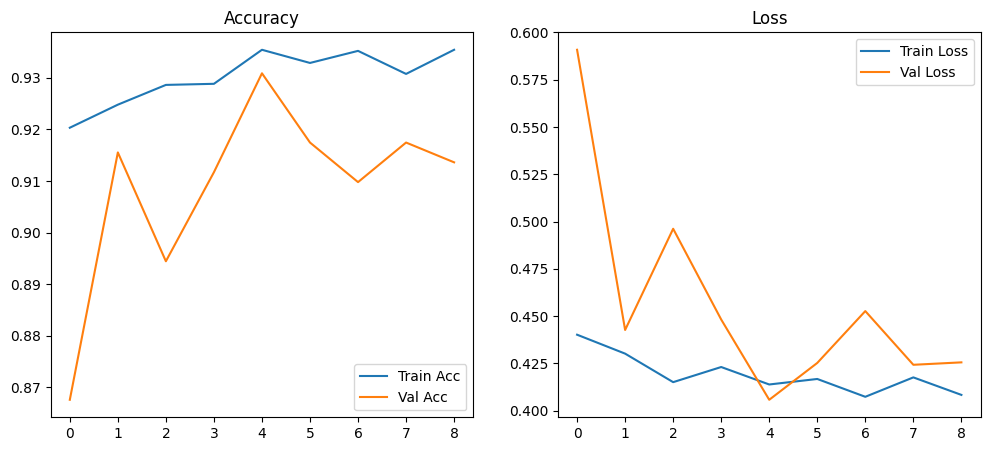

In [14]:
# Cell 9 — plots for accuracy & loss (unchanged)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.show()


In [15]:
# Cell 10 — test evaluation (unchanged)
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")


20/20 [==============================] - 3s 131ms/step - loss: 0.5264 - accuracy: 0.8926

 Test Accuracy: 89.26%
 Test Loss: 0.5264


In [17]:
# Cell 11 — last epoch metrics and simple diagnostics (unchanged)
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Train Accuracy:", round(train_acc*100, 2), "%")
print("Val Accuracy:", round(val_acc*100, 2), "%")
print("Train Loss:", round(train_loss, 4))
print("Val Loss:", round(val_loss, 4))
print("--------------------------------------------------")

# Decision logic
acc_gap = abs(train_acc - val_acc)
loss_gap = abs(train_loss - val_loss)

if acc_gap < 0.03 and loss_gap < 0.05:
    print("✅ Model is well-generalized (Balanced).")
elif train_acc > val_acc and acc_gap >= 0.05:
    print("⚠️ Model is overfitting — try reducing epochs, increasing dropout, or adding augmentation.")
elif train_acc < val_acc and acc_gap >= 0.05:
    print("⚠️ Model is underfitting — try training longer or reducing dropout slightly.")
else:
    print("ℹ️ Model is borderline balanced — check plots to confirm.")


Train Accuracy: 93.55 %
Val Accuracy: 91.36 %
Train Loss: 0.4084
Val Loss: 0.4256
--------------------------------------------------
✅ Model is well-generalized (Balanced).


In [18]:
# Cell 12 — evaluate on test data and make predictions (kept same)
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n📊 Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

Y_pred = model.predict(test_gen)
threshold = 0.45
y_pred = (Y_pred > threshold).astype(int).ravel()
y_true = test_gen.classes


20/20 [==============================] - 3s 121ms/step - loss: 0.5264 - accuracy: 0.8926

📊 Test Accuracy: 89.26%
📉 Test Loss: 0.5264
20/20 [==============================] - 3s 129ms/step


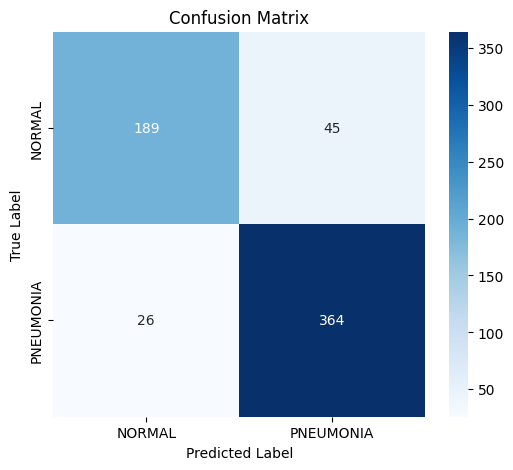


🧾 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.88      0.81      0.84       234
   PNEUMONIA       0.89      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



In [19]:
# Cell 13 — confusion matrix and classification report (unchanged)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


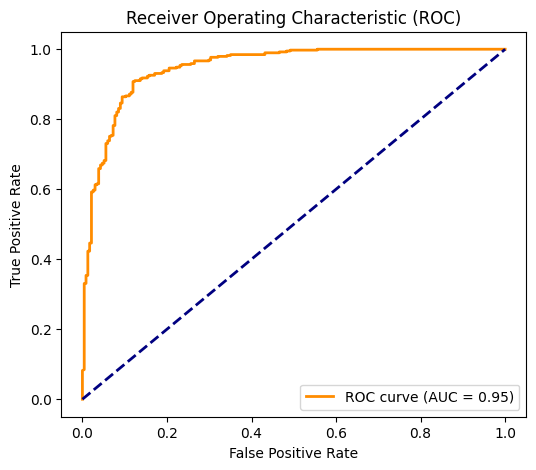

In [20]:
# Cell 14 — ROC curve and AUC (unchanged)
fpr, tpr, _ = roc_curve(y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


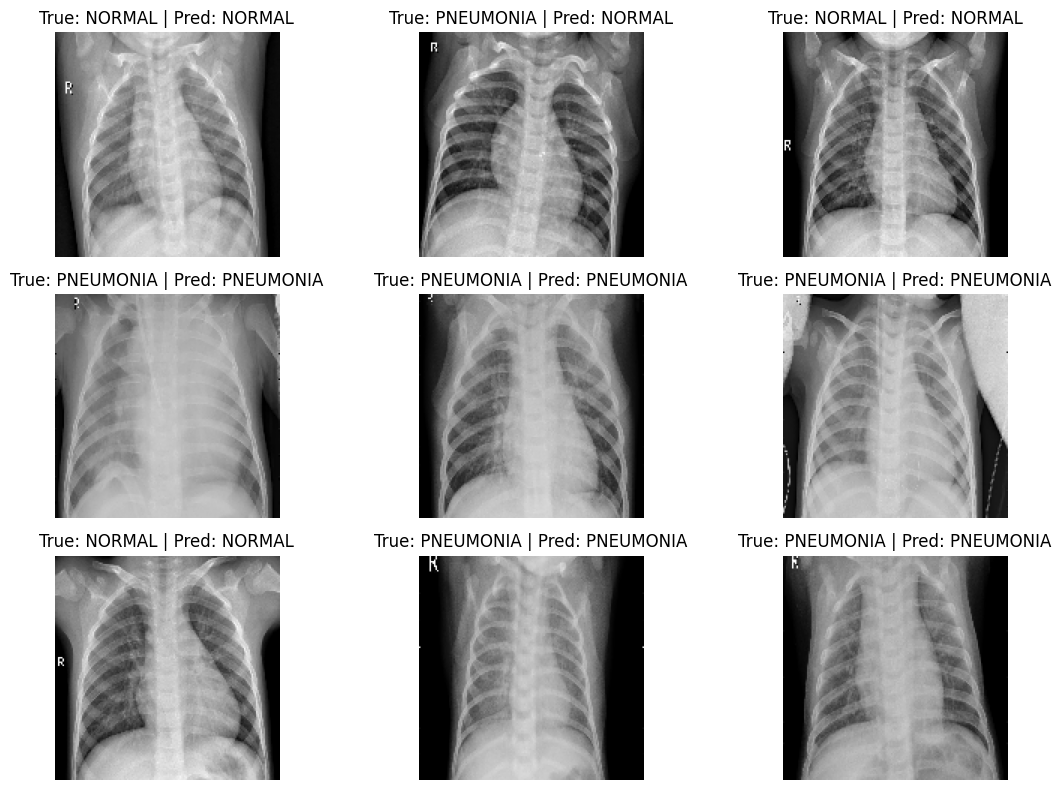

In [21]:
# Cell 15 — Sample Predictions
class_labels = list(test_gen.class_indices.keys())
plt.figure(figsize=(12, 8))

# Safely pick batches (prevent crash if < 9 batches exist)
n_batches = len(test_gen)
# Pick random indices, limited by the actual number of batches available
sample_idxs = np.random.choice(n_batches, size=min(9, n_batches), replace=False)

try:
    for i, batch_idx in enumerate(sample_idxs):
        # Get a full batch
        imgs, labels = test_gen[batch_idx]
        
        # Predict on the batch
        preds = model.predict(imgs, verbose=0)
        
        # Pick one random image from this batch to display
        img_idx_in_batch = np.random.randint(0, len(imgs))
        
        plt.subplot(3, 3, i+1)
        plt.imshow(imgs[img_idx_in_batch])
        
        true_label = class_labels[int(labels[img_idx_in_batch])]
        pred_label = class_labels[int(preds[img_idx_in_batch] > 0.5)]
        
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot samples: {e}")

In [22]:
# Cell 16 — save model locally (models/ folder is project-local)
os.makedirs("models", exist_ok=True)
model.save(os.path.join("models", "pneumonia_model.h5"))
print("✅ Model saved successfully at models/pneumonia_model.h5")


✅ Model saved successfully at models/pneumonia_model.h5


In [23]:
# Cell 17 — load saved model and run single image prediction (update img_path to your test image)
model = load_model(os.path.join("models", "pneumonia_model.h5"))

# update this path to a real image inside data/test/...
img_path = os.path.join(TEST_DIR, "NORMAL", "IM-0091-0001.jpeg")
if os.path.exists(img_path):
    img = image.load_img(img_path, target_size=(150,150))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print("Predicted: PNEUMONIA")
    else:
        print("Predicted: NORMAL")
else:
    print("Sample image not found at:", img_path)


1/1 [==============================] - 0s 276ms/step
Predicted: NORMAL
